In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize as optim
import pandas as pd
from tqdm import tqdm
import time
import os

import sympy
from sympy.solvers import solve

%matplotlib notebook

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' :  18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Meniscus

In [3]:
t = 300 # inner thickness of the capillary
n_c = 1.36
n_o = 1.467
n_w = 1.33

# absorbance coeffs
alpha_w = 4*1e-8
alpha_o = 4*1e-4

alpha_w = alpha_o = 0

In [4]:
m_s = 10 # menisc size

d = (0.25*t**2 - m_s**2)/(2*m_s)

R = np.sqrt(d**2 + 0.25*t**2)
print(f'{R = }')
print(f'{d = }')

min_theta_n = np.arctan(2*d/t)

R = 1130.0
d = 1120.0


In [5]:
def interface_y(x):
    return np.sqrt(R**2 - (x - t/2)**2) - d

def interface(y):
    '''
    given y returns the first intersection point, if found
    '''
    if y < 0 or y >= R - d:
        return None
    
    theta_1 = np.arcsin((d + y)/R)
    x1 = t/2 - R*np.cos(theta_1)
    return x1

def reflectance(theta_i,n,polarization='p'):
    if theta_i > np.pi/2:
        theta_i = np.pi - theta_i
        
    q = np.sin(theta_i)/n
    if q > 1:
        #total reflection
        return 1.
    theta_t = np.arcsin(q)
    
    r = 0.
    if polarization == 'p':
        r = (-n*np.cos(theta_i) + np.cos(theta_t))/(n*np.cos(theta_i) + np.cos(theta_t))
    else:
        r = (np.cos(theta_i) - n*np.cos(theta_t))/(np.cos(theta_i) + n*np.cos(theta_t))
    return r**2

def transmittance(theta_i,n,polarization='p'):
    return 1. - reflectance(theta_i,n,polarization)

class interface_point():
    def __init__(self,x, theta_in_abs = 0, polarization = 'p'):
        self.x = x
        self.y = interface_y(x)
        self.normal_theta = np.arccos((self.x - t/2)/R)
        
        self.theta_in = self.normal_theta - theta_in_abs
        
        #refractive indeces
        # beam comes form water
        self.n = n_o/n_w
        self.theta_t = np.arcsin(np.sin(self.theta_in)/self.n)
        
        if self.theta_in > 0.5*np.pi:
            # beam comes from oil
            self.n = 1/self.n
            self.theta_t = np.pi - np.arcsin(np.sin(self.theta_in)/self.n)
            
        self.theta_r_abs = 2*self.theta_in + theta_in_abs - np.pi
        
        self.theta_t_abs = self.normal_theta - self.theta_t
        
        if np.sin(self.theta_in)/self.n > 1:
            self.theta_t = None
            self.theta_t_abs = None
        
        #Reflectance and Transmittance
        self.R = reflectance(self.theta_in, self.n, polarization)
        self.T = 1. - self.R
        
#         print(f'{self.theta_r_abs = }, {self.theta_t_abs = }')
        
        
class Ray():
    def __init__(self, y0, theta0=0, I0=1., polarization='p'):
        self.polarization = polarization
        self.rays = []
        self.intensities = []
        self.points = []
        self.final_ys = []
        self.final_Is = []
        
        x = sympy.Symbol('x')
        
        theta1 = 0
        if y0 > 0:
            theta1 = np.arcsin(n_c/n_o*np.sin(theta0))
        else:
            theta1 = np.arcsin(n_c/n_w*np.sin(theta0))
        
        sol = solve((y0 + x*np.tan(theta1) + d)**2 - R**2 + (x - t/2)**2 , x)
        x1 = complex(sol[0])
        y1 = 0
        straight_ray = False
        
        if np.imag(x1) != 0:
            straight_ray = True
        else:
            x1 = np.real(x1)
            y1 = y0 + x1*np.tan(theta1)
            if y1 < 0:
                x1 = np.real(complex(sol[1]))
                y1 = y0 + x1*np.tan(theta1)
                if y1 < 0:
                    straight_ray = True

        def early_conclude(fluid):
            n_hit = 1
            if fluid == 'o':
                n_hit = n_o
            else:
                n_hit = n_w
            self.rays.append(((0,t), (y0,y0 + t*np.tan(theta1))))
            I = I0*transmittance(theta_i=theta0,n=n_hit/n_c,
                                 polarization=self.polarization)
            l = t/np.cos(theta1)
            if fluid == 'o':
                I *= np.exp(-alpha_o*l)
            else:
                I *= np.exp(-alpha_w*l)
            self.intensities.append(I)
            self.final_ys.append(y0 + t*np.tan(theta1))
            self.final_Is.append(I*transmittance(theta_i=theta1,n=n_c/n_hit,polarization=self.polarization))
        
            
        if straight_ray:
            if y0 > 0:
                early_conclude('o')
            else: early_conclude('w')
            
        else:
            # more complicated problem
            I = 0
            l = x1/np.cos(theta1)
            if y0 > 0:
                I = I0*transmittance(theta_i=theta0,n=n_o/n_c,
                                     polarization=self.polarization)*np.exp(-alpha_o*l)
            else:
                I = I0*transmittance(theta_i=theta0,n=n_w/n_c,
                                     polarization=self.polarization)*np.exp(-alpha_w*l)
            
            self.rays.append(((0,x1), (y0,y1)))
            self.intensities.append(I)
            
            self.propagate(x1=x1,theta1=theta1, I=I)
            
        
        
    def propagate(self,x1, theta1, I):
        '''
        Assumes to start impinging on the interface
        '''

        def conclude(theta_abs, y, I_coeff, fluid='o'):
            n_hit = 1.
            if fluid == 'o':
                n_hit = n_o
            else:
                n_hit = n_w
            
            if np.abs(theta_abs) >= np.pi/2:
                x2 = x1 + 50*np.cos(theta_abs)
                y2 = y + 50*np.sin(theta_abs)
                self.rays.append(((x1,x2), (y,y2)))
                self.intensities.append(I_coeff*I)
                return
            
            x2 = t
            y2 = y + (x2 - x1)*np.tan(theta_abs)
            l = (x2 - x1)/np.cos(theta_abs)
            I1 = I_coeff*I
            if fluid == 'o':
                I1 *= np.exp(-alpha_o*l)
            else:
                I1 *= np.exp(-alpha_w*l)
            self.rays.append(((x1,x2), (y,y2)))
            self.intensities.append(I1)
            self.final_ys.append(y2)
            self.final_Is.append(I1*transmittance(theta_i=theta_abs,
                                                         n=n_c/n_hit, polarization=self.polarization))


        p = interface_point(x1,theta1, polarization=self.polarization)
        self.points.append(p)
        
        # transmitted beam
        if p.theta_t != None:
            if p.theta_t <= np.pi/2:
                # no more interactions with interface, path in oil
                conclude(theta_abs=p.theta_t_abs, y=p.y, I_coeff=p.T, fluid='o')
            else:
                d_theta_n = 2*p.theta_t - np.pi
                theta_n = p.normal_theta - d_theta_n
                if theta_n < min_theta_n:
                    #no more interaction with interface, path in water
                    conclude(theta_abs=p.theta_t_abs, y=p.y, I_coeff=p.T, fluid='w')
                else:
                    # path in water with another interaction
                    x2 = t/2 + R*np.cos(theta_n)
                    y2 = p.y + (x2 - x1)*np.tan(p.theta_t_abs)
                    self.rays.append(((x1,x2), (p.y,y2)))
                    I1 = p.T*I*np.exp(-alpha_w*(x2 - x1)/np.cos(p.theta_t_abs))
                    self.intensities.append(I1)

                    self.propagate(x1=x2, theta1=p.theta_t_abs, I=I1)
        
        # reflected beam
        if p.theta_in >= np.pi/2:
            # no more interactions with interface, path in oil
            conclude(theta_abs=p.theta_r_abs, y=p.y, I_coeff=p.R, fluid='o')
        else:
            d_theta_n = np.pi - 2*p.theta_in
            theta_n = p.normal_theta - d_theta_n
            if theta_n < min_theta_n:
                #no more interaction with interface, path in water
                conclude(theta_abs=p.theta_r_abs, y=p.y, I_coeff=p.R, fluid='w')
            else:
                # path in water with another interaction
                x2 = t/2 + R*np.cos(theta_n)
                y2 = p.y + (x2 - x1)*np.tan(p.theta_r_abs)
                self.rays.append(((x1,x2), (p.y,y2)))
                I1 = p.R*I*np.exp(-alpha_w*(x2 - x1)/np.cos(p.theta_r_abs))
                self.intensities.append(I1)

                self.propagate(x1=x2, theta1=p.theta_r_abs, I=I1)




In [6]:
ray1 = Ray(100,theta0=-np.pi/10,polarization='s')
print(f'{ray1.rays = }\n{ray1.final_ys = }\n{ray1.final_Is = }')

print(f'\n\nTotal intensity reaching the end: {np.sum(ray1.final_Is)}')

ray1.rays = [((0, 300), (100, 10.296882446880247))]
ray1.final_ys = [10.296882446880247]
ray1.final_Is = [0.9965541606046301]


Total intensity reaching the end: 0.9965541606046301


<IPython.core.display.Javascript object>


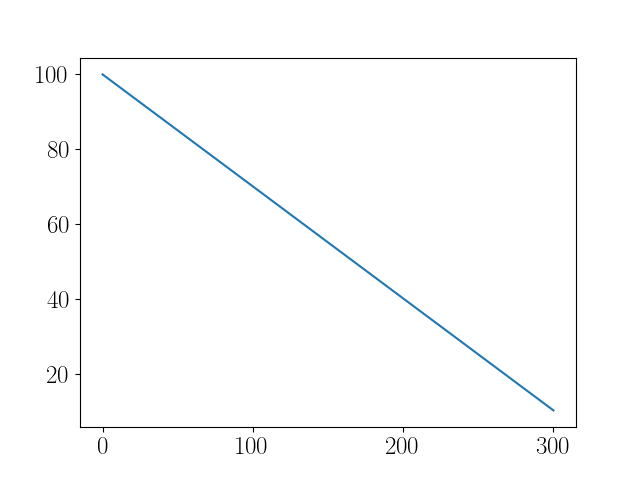

In [35]:
for ray in ray1.rays:
    plt.plot(ray[0],ray[1])


<IPython.core.display.Javascript object>


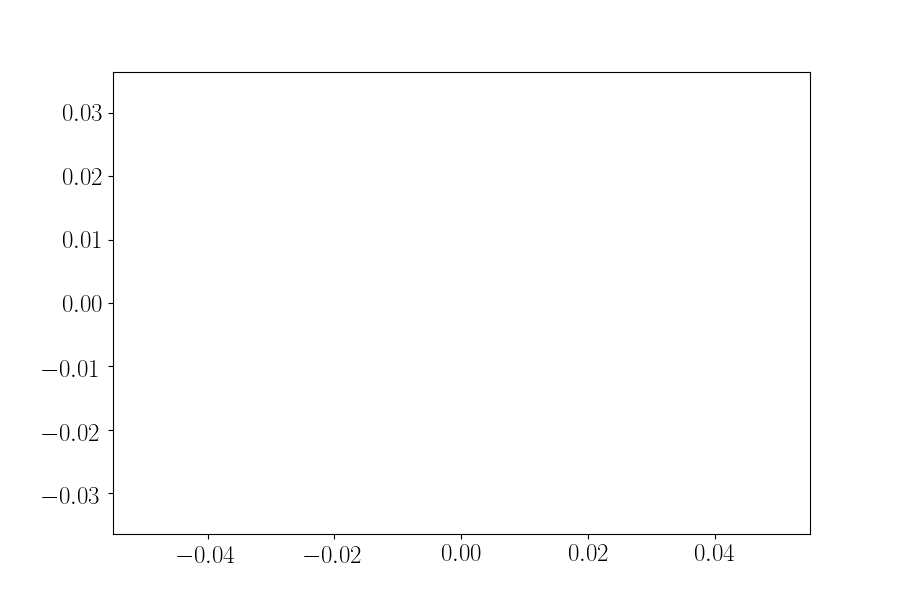

NameError: name 'xs' is not defined

In [36]:
fig,ax = plt.subplots(figsize=(9,6))
ax.axis('equal')
plt.plot(xs, interface_y(xs))
plt.vlines([0,t], *ax.get_ylim())
plt.xlim(*ax.get_xlim())
plt.ylim(*ax.get_ylim())

### Transmitted light profile

In [ ]:
m_ss = np.arange(10, 160, 10)
theta0_max = np.pi/6

theta0s = np.linspace(-theta0_max, theta0_max, 100)
start_time = time.time()

for k,m in enumerate(m_ss[::5]):
    m_s = m # menisc size

    d = (0.25*t**2 - m_s**2)/(2*m_s)

    R = np.sqrt(d**2 + 0.25*t**2)
    
    it_time = time.time() - start_time
    
    hours = int(it_time/3600)
    it_time -= hours*3600
    mins = int(it_time/60)
    secs = int(it_time - mins*60)
    
    print(f'\n\n ITERATION {k + 1}: starting @ {hours} h: {mins} m {secs} s')
    print(f'{m_s = }')
    print(f'{R = }')
    print(f'{d = }')
    
    folder = f'no_abs_pi6_m{m}'
    if not os.path.exists(folder):
        os.mkdir(folder)

    min_theta_n = np.arctan(2*d/t)
    
    y0_min = -t*np.tan(theta0_max) - 0.5
    y0_max = max(R*np.cos(theta0_max) - d, 0) + min(0.5*t + R*np.sin(theta0_max), t)*np.tan(theta0_max)
    
    y0s = np.arange(y0_min, y0_max + 1, 2)
    
    print(f'{len(y0s)} y0 points')
    time.sleep(1)
    
    
    final_Is = []
    final_ys = []

    for i,y0 in enumerate(y0s):
#         print(f'ITERATION {i}')
        final_Is.append([])
        final_ys.append([])
        for theta0 in tqdm(theta0s):
            ray = Ray(y0,theta0)
            final_Is[-1].append(ray.final_Is)
            final_ys[-1].append(ray.final_ys)
            
    f_Is = [np.concatenate(f_I) for f_I in final_Is]
    f_dys = [np.concatenate(f_y) - y0s[i] for i,f_y in enumerate(final_ys)]

    np.save(f'{folder}/f_Is',f_Is)
    np.save(f'{folder}/f_dys', f_dys)
    np.save(f'{folder}/y0s', y0s)
    np.save(f'{folder}/theta0s', theta0s)
    
    



 ITERATION 1: starting @ 0 h: 0 m 0 s
m_s = 10
R = 1130.0
d = 1120.0
174 y0 points


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:13<00:04,  5.11it/s]

### THIS CELL TAKES A LOT OF TIME

In [33]:
# theta0s = np.linspace(-np.pi/10, np.pi/10, 100)
# y0s = np.linspace(t*np.tan(theta0s[0]),100, 100)

# final_Is = []
# final_ys = []

for i,y0 in enumerate(y0s[-1:]):
    print(f'ITERATION {i}')
#     final_Is.append([])
#     final_ys.append([])
    for theta0 in tqdm(theta0s):
        ray = Ray(y0,theta0)
#         final_Is[-1].append(ray.final_Is)
#         final_ys[-1].append(ray.final_ys)
        
        for i,r in enumerate(ray.rays):
            plt.plot(r[0], r[1], alpha=ray.intensities[i], color='red')
    break

  1%|          | 1/100 [00:00<00:11,  8.42it/s]

ITERATION 0


100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


<IPython.core.display.Javascript object>


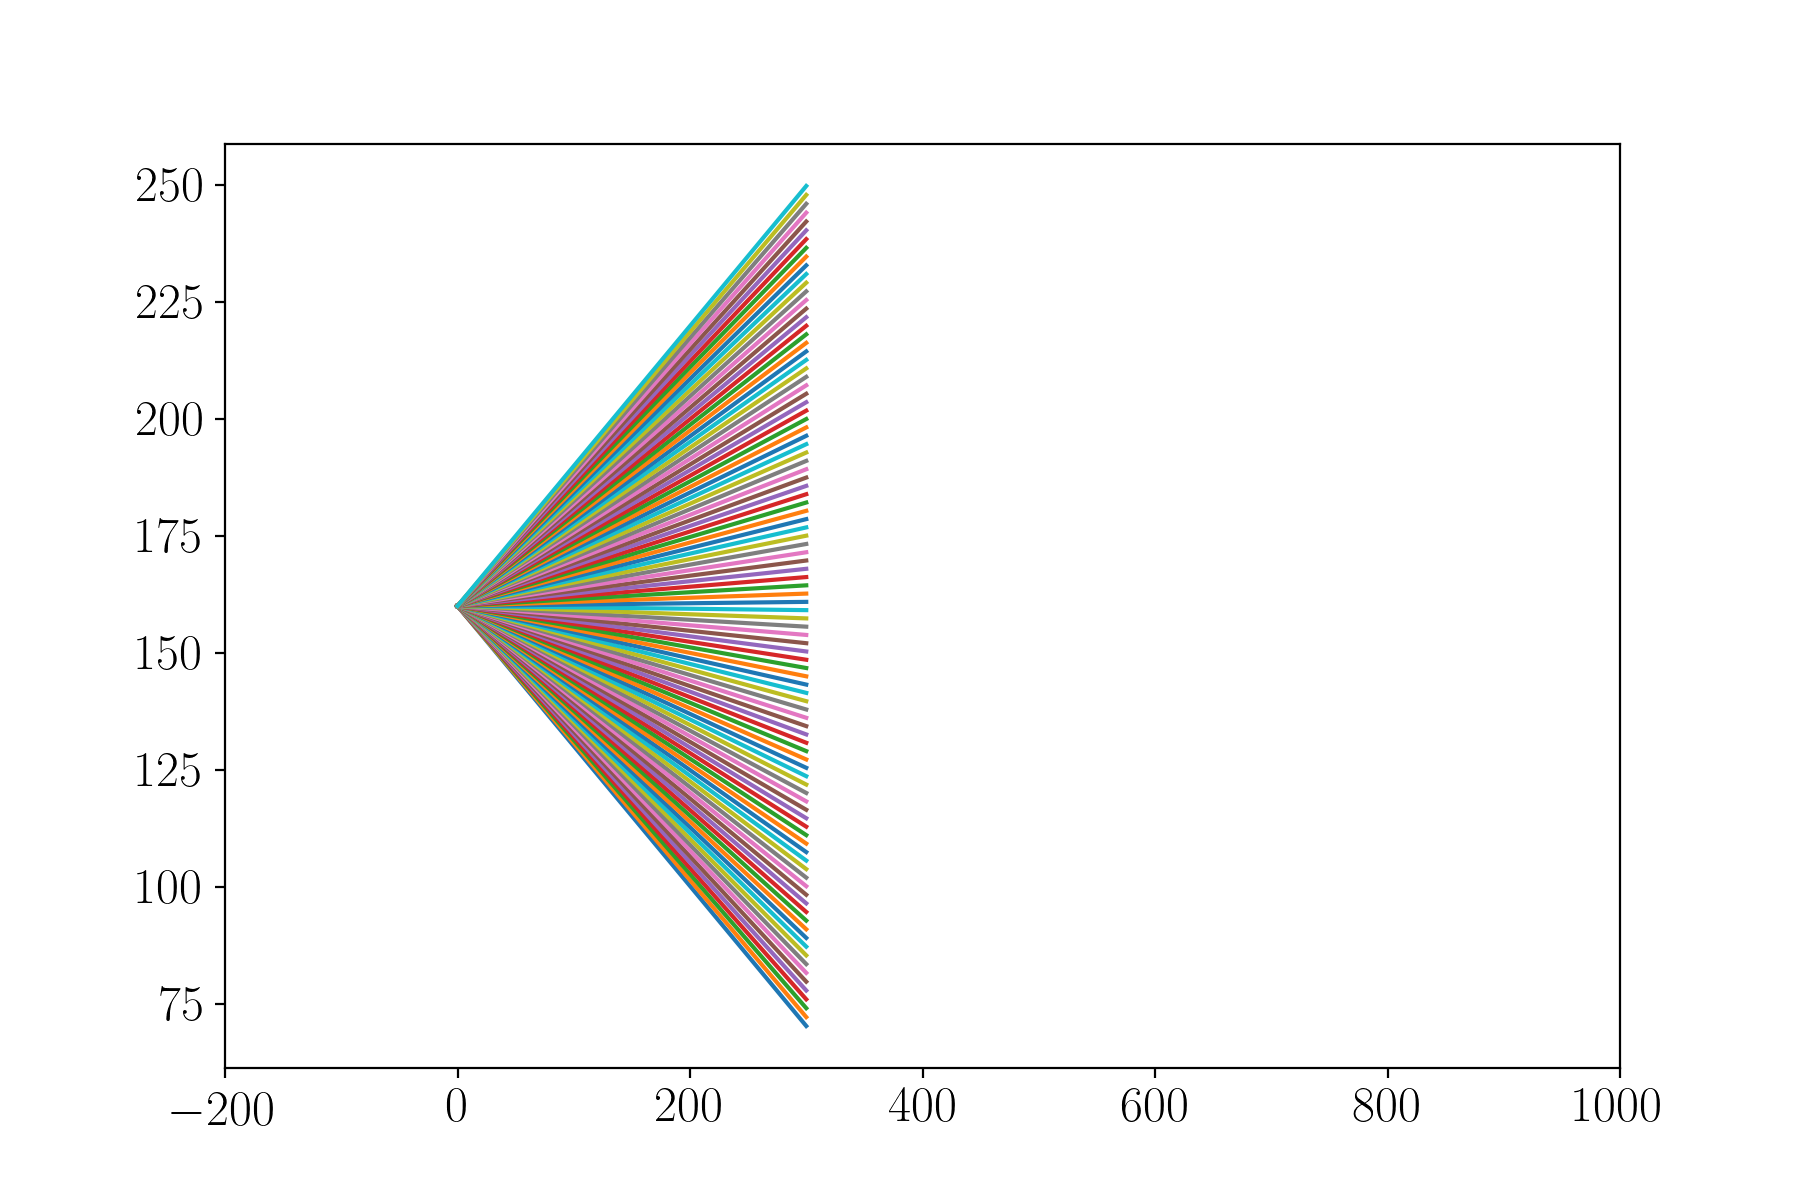

(-200.0, 1000.0)

In [167]:
fig,ax = plt.subplots(figsize=(9,6))
plt.xlim(-200, 1000)

In [37]:
## LOAD

folder = 'no_abs_pi10_m10'

y0s = np.load(f'{folder}/y0s.npy',allow_pickle=True)
f_Is = np.load(f'{folder}/f_Is.npy', allow_pickle=True)
f_dys = np.load(f'{folder}/f_dys.npy', allow_pickle=True)

### Simulating half of the waveform

In [7]:
y_emitters = np.linspace(-500, 500, 501)
weights_emitters = np.ones_like(y_emitters)


#position of the collector fiber
center = 0
hwidth = 500

y_max = center + hwidth
y_min = center - hwidth

def y0_to_index(y0):
    i = int((y0 - y0s[0])/(y0s[-1] - y0s[0])*len(y0s))
    i = max(0,i)
    i = min(i, len(y0s) - 1)
    return i

@np.vectorize
def collection_coeff(y):
    if y < y_max and y > y_min:
        return 1.
    return 0

def collected_intensity(y_drop, plot=False):
    I_tot = 0.
    
    if plot:
        fig,ax = plt.subplots(figsize=(9,6))
        ax.axis('equal')
        ax.set_xlim(-800, 800)
        plt.hlines([0,t], -800, 800, color='black')
        plt.vlines([y_emitters[0], y_emitters[-1]], 300, 350, color='black')
        plt.vlines([y_min, y_max], -50, 0, color='black')
        plt.fill([y_emitters[0]+t*np.tan(theta0s[0]), y_emitters[0], 
                  y_emitters[-1], y_emitters[-1]+t*np.tan(theta0s[-1])],
                 [0,t,t,0], color='green', alpha=0.3)
        
        xs = np.arange(0,t+1, 1)
        plt.fill([-800] + list(interface_y(xs) + y_drop) + [-800], [0] + list(xs) + [t], color='blue', alpha=0.2)
        
        ax2 = ax.twinx()
        y_ss = []
        w_ss = []
    
    for i,y in enumerate(y_emitters):
        index = y0_to_index(y - y_drop)
#         print(index)
        I_coeffs = collection_coeff(f_dys[index] + y)
        I_tot += np.dot(f_Is[index], I_coeffs)*weights_emitters[i]
        
        if plot:
            y_ss += list(f_dys[index] + y)
            w_ss += list(f_Is[index]*weights_emitters[i])
    
    if plot:
        ax2.hist(y_ss, weights=w_ss, color='red', alpha=0.2, range=ax.get_xlim(), bins=100)
        ax.set_title(f'I tot = {I_tot :.0f}')
    
    return I_tot

<IPython.core.display.Javascript object>


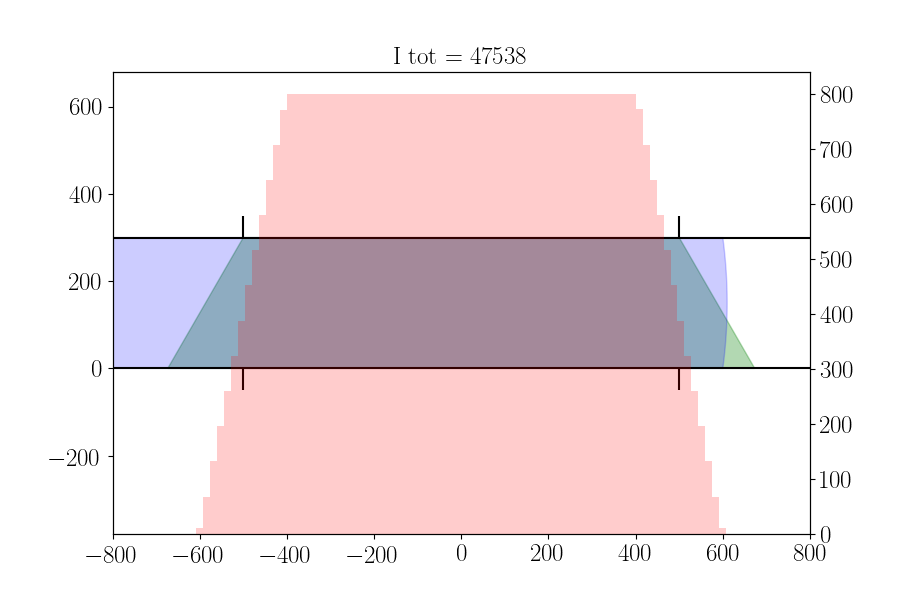

47537.73563491878

In [39]:
collected_intensity(600, plot=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.14it/s]


<IPython.core.display.Javascript object>


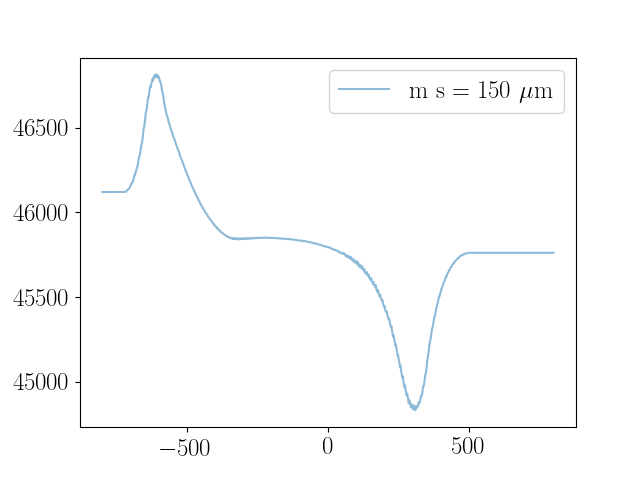

In [8]:
m_s = 150

folder = f'no_abs_pi6_m{m_s}'

y0s = np.load(f'{folder}/y0s.npy',allow_pickle=True)
f_Is = np.load(f'{folder}/f_Is.npy', allow_pickle=True)
f_dys = np.load(f'{folder}/f_dys.npy', allow_pickle=True)


y_drops = np.linspace(-800, 800, 1000)
c_Is = []

for y_drop in tqdm(y_drops):
    c_Is.append(collected_intensity(y_drop))
    
c_Is = np.array(c_Is)


plt.plot(y_drops, c_Is, label=f'm s = {m_s} $\mu$m', alpha=0.5)
plt.legend()

<IPython.core.display.Javascript object>


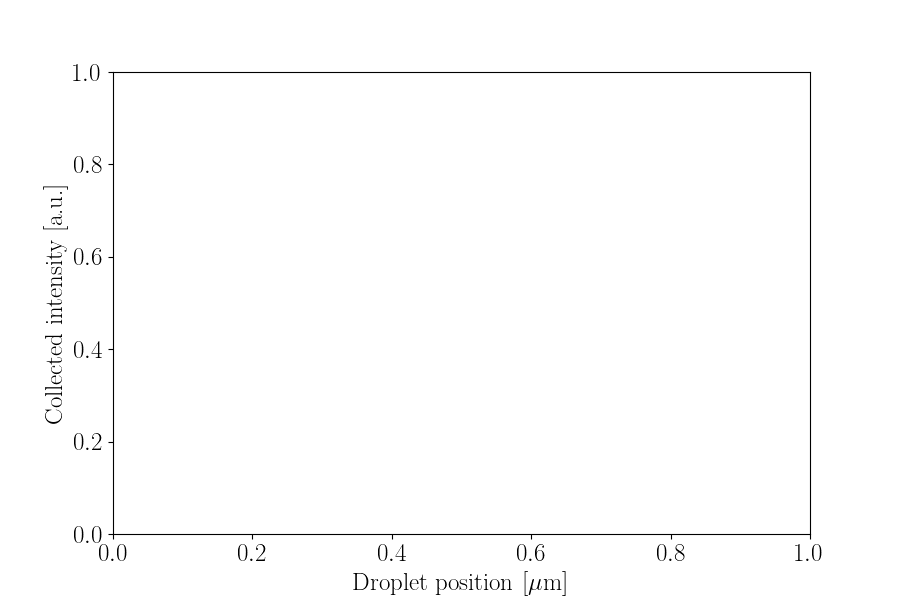

Text(0, 0.5, 'Collected intensity [a.u.]')

In [42]:
fig,ax = plt.subplots(figsize=(9,6))
plt.xlabel('Droplet position [$\mu$m]')
plt.ylabel('Collected intensity [a.u.]')

In [70]:
plt.ylim(40000, 49000)

(40000.0, 49000.0)

In [90]:
# fig.tight_layout()
fig.savefig('Shoulder_pi6.png')

## Simulating the whole waveform

In [9]:
y_emitters = np.linspace(-500, 500, 501)
weights_emitters = np.ones_like(y_emitters)

theta0_max = np.pi/6
theta0s = np.linspace(-theta0_max, theta0_max, 100)


#position of the collector fiber
center = 0
hwidth = 500

drop_lenght = 1500
fms = 70 # forward menisc size
bms = 30 # backward menisc size


fd = (0.25*t**2 - fms**2)/(2*fms)
fR = np.sqrt(fd**2 + 0.25*t**2)

@np.vectorize
def f_interface_y(x):
    return np.sqrt(fR**2 - (x - t/2)**2) - fd

bd = (0.25*t**2 - bms**2)/(2*bms)
bR = np.sqrt(bd**2 + 0.25*t**2)

@np.vectorize
def b_interface_y(x):
    return -(np.sqrt(bR**2 - (x - t/2)**2) - bd)

y_max = center + hwidth
y_min = center - hwidth

folder_f = f'no_abs_pi6_m{fms}'

y0s_f = np.load(f'{folder_f}/y0s.npy',allow_pickle=True)
f_Is_f = np.load(f'{folder_f}/f_Is.npy', allow_pickle=True)
f_dys_f = np.load(f'{folder_f}/f_dys.npy', allow_pickle=True)

folder_b = f'no_abs_pi6_m{bms}'

y0s_b = np.load(f'{folder_b}/y0s.npy',allow_pickle=True)
f_Is_b = np.load(f'{folder_b}/f_Is.npy', allow_pickle=True)
f_dys_b = np.load(f'{folder_b}/f_dys.npy', allow_pickle=True)

def y0_to_index(y0, y0s):
    i = int((y0 - y0s[0])/(y0s[-1] - y0s[0])*len(y0s))
    i = max(0,i)
    i = min(i, len(y0s) - 1)
    return i

@np.vectorize
def collection_coeff(y):
    if y < y_max and y > y_min:
        return 1.
    return 0

def collected_intensity(y_drop, plot=False, reference_profile=None, **kwargs):
    figsize = kwargs.pop('figsize', (9,6))
    xlim = kwargs.pop('xlim', (-800, 800))
    bins = kwargs.pop('bins', 100)
    ylim = kwargs.pop('ylim', None)
    
    I_tot = 0.
    
    if plot:
        fig,ax = plt.subplots(figsize=figsize)
        ax.axis('equal')
        ax.set_xlim(*xlim)
        plt.hlines([0,t], *xlim, color='black')
        plt.vlines([y_emitters[0], y_emitters[-1]], t, t+50, color='black')
        plt.vlines([y_min, y_max], -50, 0, color='black')
        plt.fill([y_emitters[0]+t*np.tan(theta0s[0]), y_emitters[0], 
                  y_emitters[-1], y_emitters[-1]+t*np.tan(theta0s[-1])],
                 [0,t,t,0], color='green', alpha=0.3)
        
        xs = np.arange(0,t+1, 1)
        plt.fill(list(b_interface_y(xs)[::-1] - drop_lenght + y_drop) + list(f_interface_y(xs) + y_drop),
                 list(xs[::-1]) + list(xs), color='blue', alpha=0.2)
        
        ax2 = ax.twinx()
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_ylabel('Intensity profile [a.u.]')
        
        ax.set_xlabel('Longitudinal coord. [$\mu$m]')
        ax.set_ylabel('Transversal coord. [$\mu$m]')
        
        y_ss = []
        w_ss = []
        
    y_hist = None
    I_hist = None
    
    for i,y in enumerate(y_emitters):
        # forward meniscus
        index = y0_to_index(y - y_drop,y0s=y0s_f)
        I_coeffs = collection_coeff(f_dys_f[index] + y)
        I_tot += 0.5*np.dot(f_Is_f[index], I_coeffs)*weights_emitters[i]
        
        if plot:
            y_ss += list(f_dys_f[index] + y)
            w_ss += list(0.5*f_Is_f[index]*weights_emitters[i])
            
        # forward meniscus
        index = y0_to_index(y_drop - y - drop_lenght,y0s=y0s_b)
        I_coeffs = collection_coeff(-f_dys_b[index] + y)
        I_tot += 0.5*np.dot(f_Is_b[index], I_coeffs)*weights_emitters[i]
        
        if plot:
            y_ss += list(-f_dys_b[index] + y)
            w_ss += list(0.5*f_Is_b[index]*weights_emitters[i])
    
    if plot:
        I_hist, y_hist = np.histogram(y_ss, weights=w_ss, range=ax.get_xlim(), bins=bins)
        y_hist = 0.5*(y_hist[1:] + y_hist[:-1])
        if reference_profile:
            ax2.plot(reference_profile[1],I_hist - reference_profile[2], color='orange')
            ax.set_title(f'dI tot = {I_tot - reference_profile[0] :.0f}')
            ax2.set_ylim(*ylim)
        else:
            ax2.plot(y_hist,I_hist, color='red')
            ax.set_title(f'I tot = {I_tot :.0f}')
        fig.tight_layout()
        
    if reference_profile:
        return I_tot - reference_profile[0], y_hist, I_hist - reference_profile[2]
    
    return I_tot, y_hist, I_hist

<IPython.core.display.Javascript object>


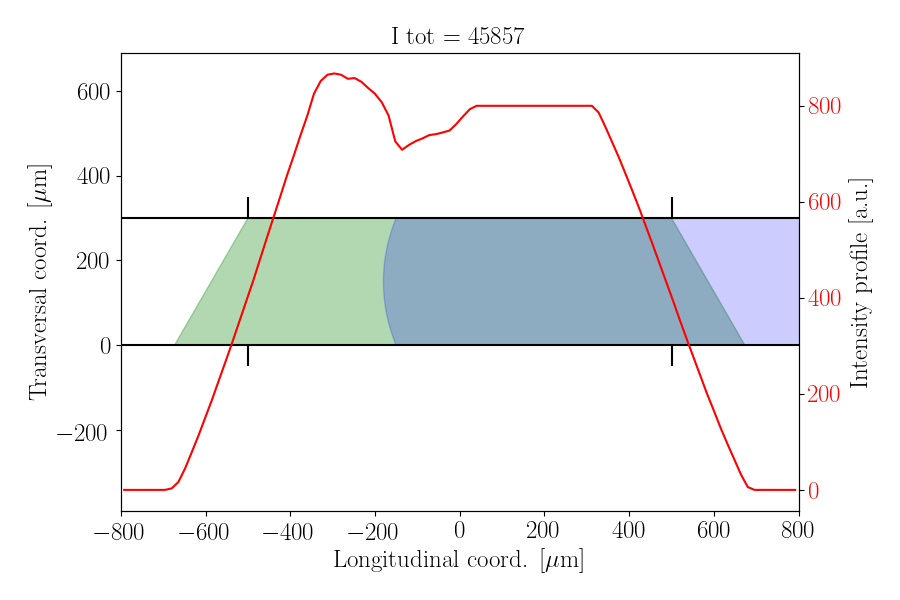

In [178]:
 reference_profile = collected_intensity(1350, plot=True)

#_ = collected_intensity(1000, plot=True, reference_profile=reference_profile, ylim = (-100, 100))

In [11]:
y_drops = np.arange(-800, 800 + drop_lenght, 10)
c_Is = []

for y_drop in tqdm(y_drops):
    c_Is.append(collected_intensity(y_drop)[0])
    
c_Is = np.array(c_Is)


plt.plot(y_drops, c_Is, alpha=0.5)
# plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:36<00:00,  8.48it/s]


<IPython.core.display.Javascript object>


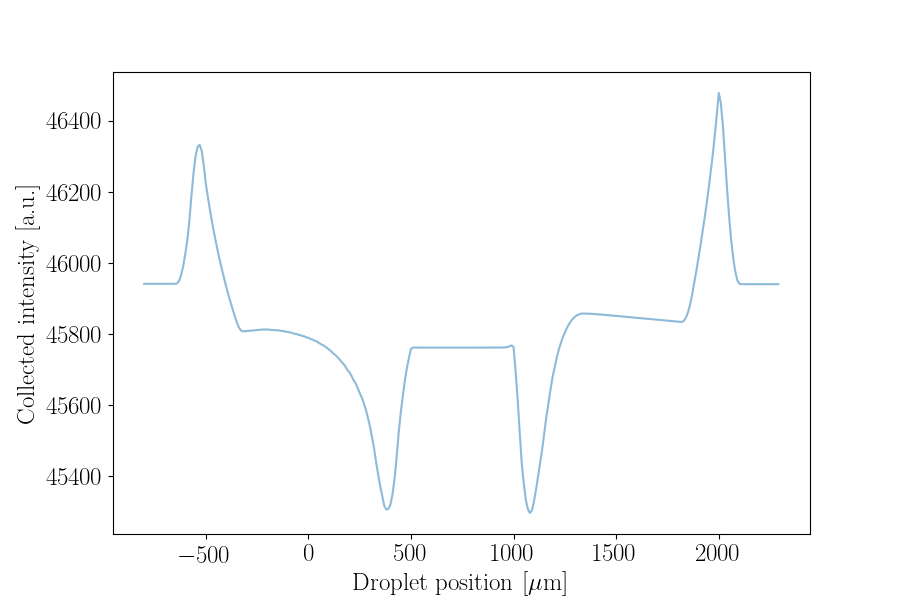

Text(0, 0.5, 'Collected intensity [a.u.]')

In [10]:
fig,ax = plt.subplots(figsize=(9,6))
plt.xlabel('Droplet position [$\mu$m]')
plt.ylabel('Collected intensity [a.u.]')

In [104]:
fig.savefig('whole_waveform1.png')

### Study of polarization

In [134]:
y0s = np.arange(-1,32,0.1)

rays_p = []
rays_s = []
for y0 in y0s:
    rays_p.append(Ray(y0, polarization='p'))
    rays_s.append(Ray(y0, polarization='s'))

<ipython-input-87-76fcae50842c>:43: RuntimeWarning: invalid value encountered in arcsin
  self.theta_t = np.arcsin(np.sin(self.theta_in)/self.n)


<IPython.core.display.Javascript object>


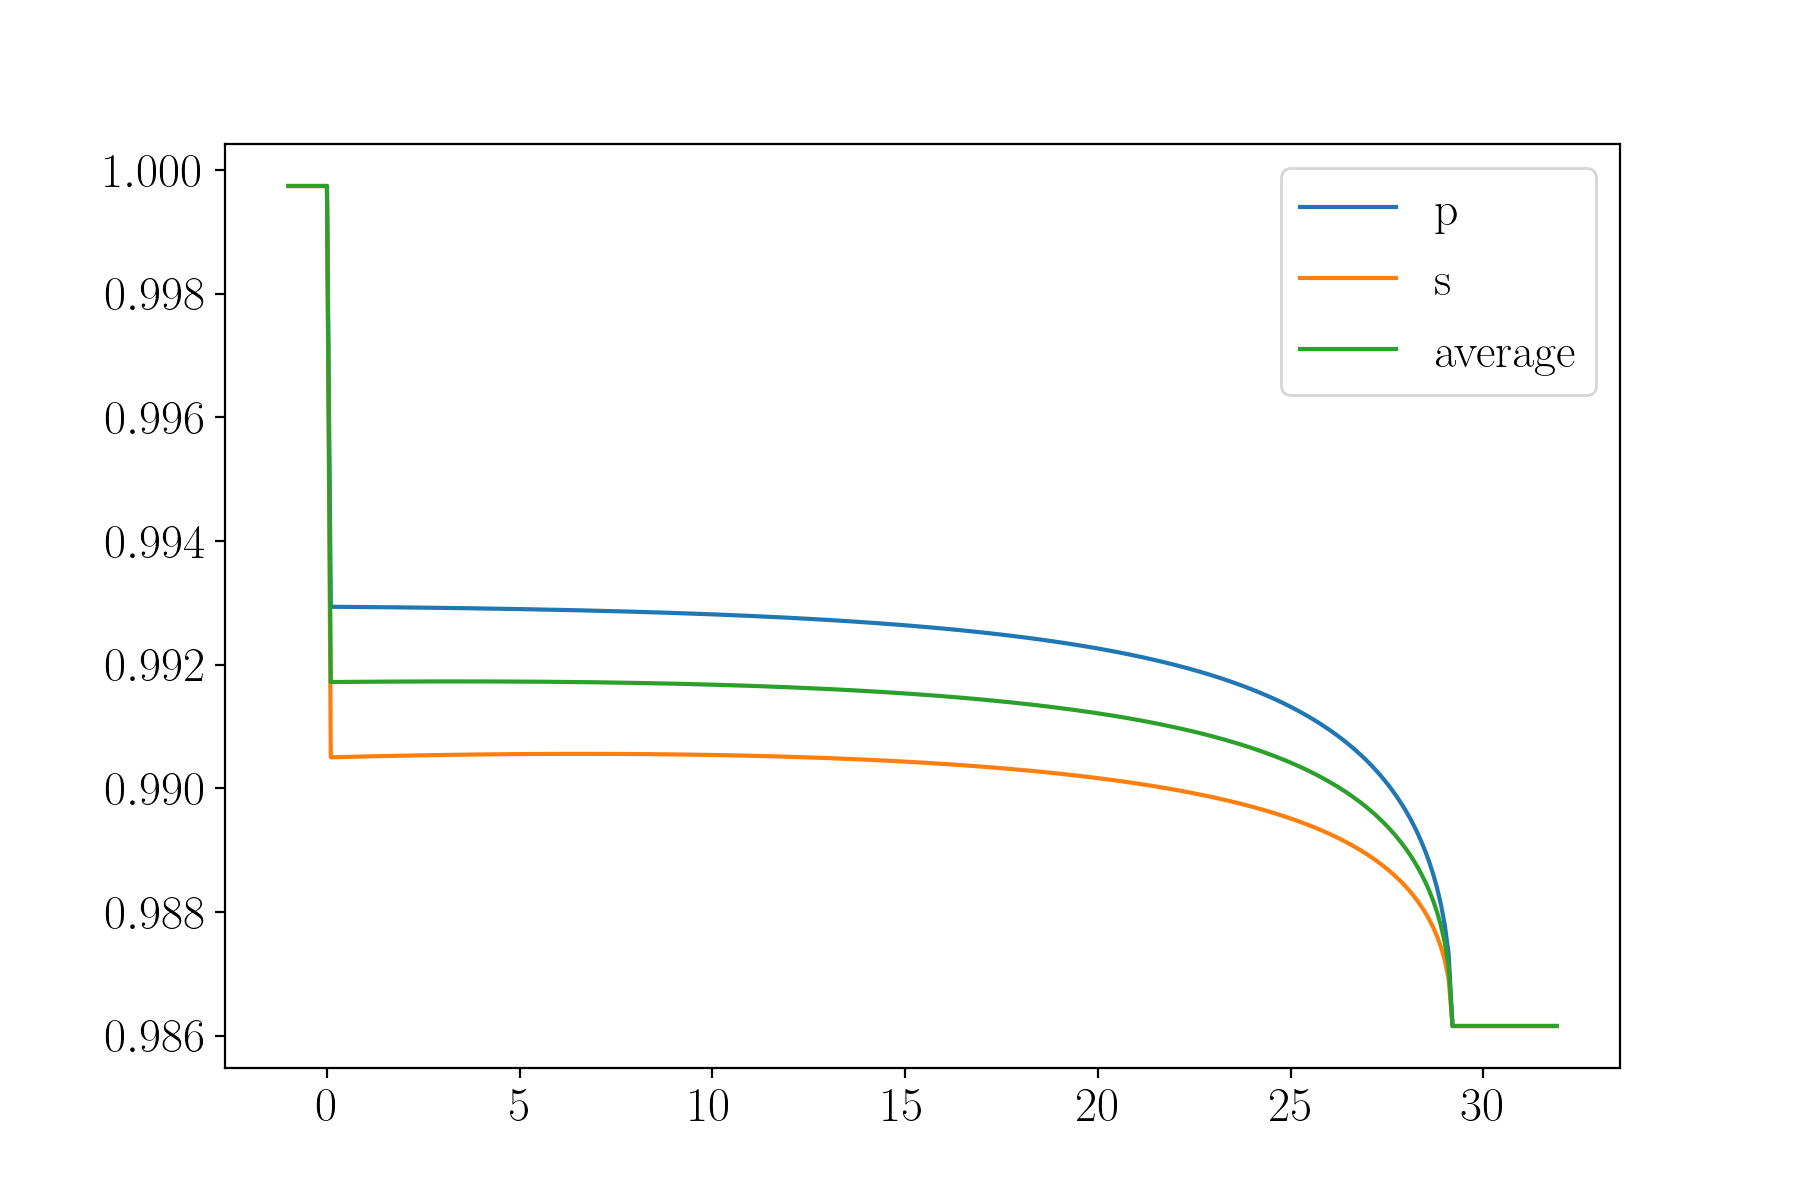

In [135]:
plt.figure(figsize=(9,6))

I_p = np.array([np.sum(r.final_Is) for r in rays_p])
I_s = np.array([np.sum(r.final_Is) for r in rays_s])

plt.plot(y0s, I_p, label='p')
plt.plot(y0s, I_s, label='s')
plt.plot(y0s, 0.5*(I_p + I_s), label='average')
plt.legend()

In [140]:
collection_tolerance = 100


I_p_constrained = []

for i,r in enumerate(rays_p):
    I_c = 0.
    for j,I in enumerate(r.final_Is):
        if np.abs(r.final_ys[j] - y0s[i]) < collection_tolerance:
            I_c += I
    I_p_constrained.append(I_c)
    
I_p_constrained = np.array(I_p_constrained)

I_s_constrained = []

for i,r in enumerate(rays_s):
    I_c = 0.
    for j,I in enumerate(r.final_Is):
        if np.abs(r.final_ys[j] - y0s[i]) < collection_tolerance:
            I_c += I
    I_s_constrained.append(I_c)
    
I_s_constrained = np.array(I_s_constrained)

<IPython.core.display.Javascript object>


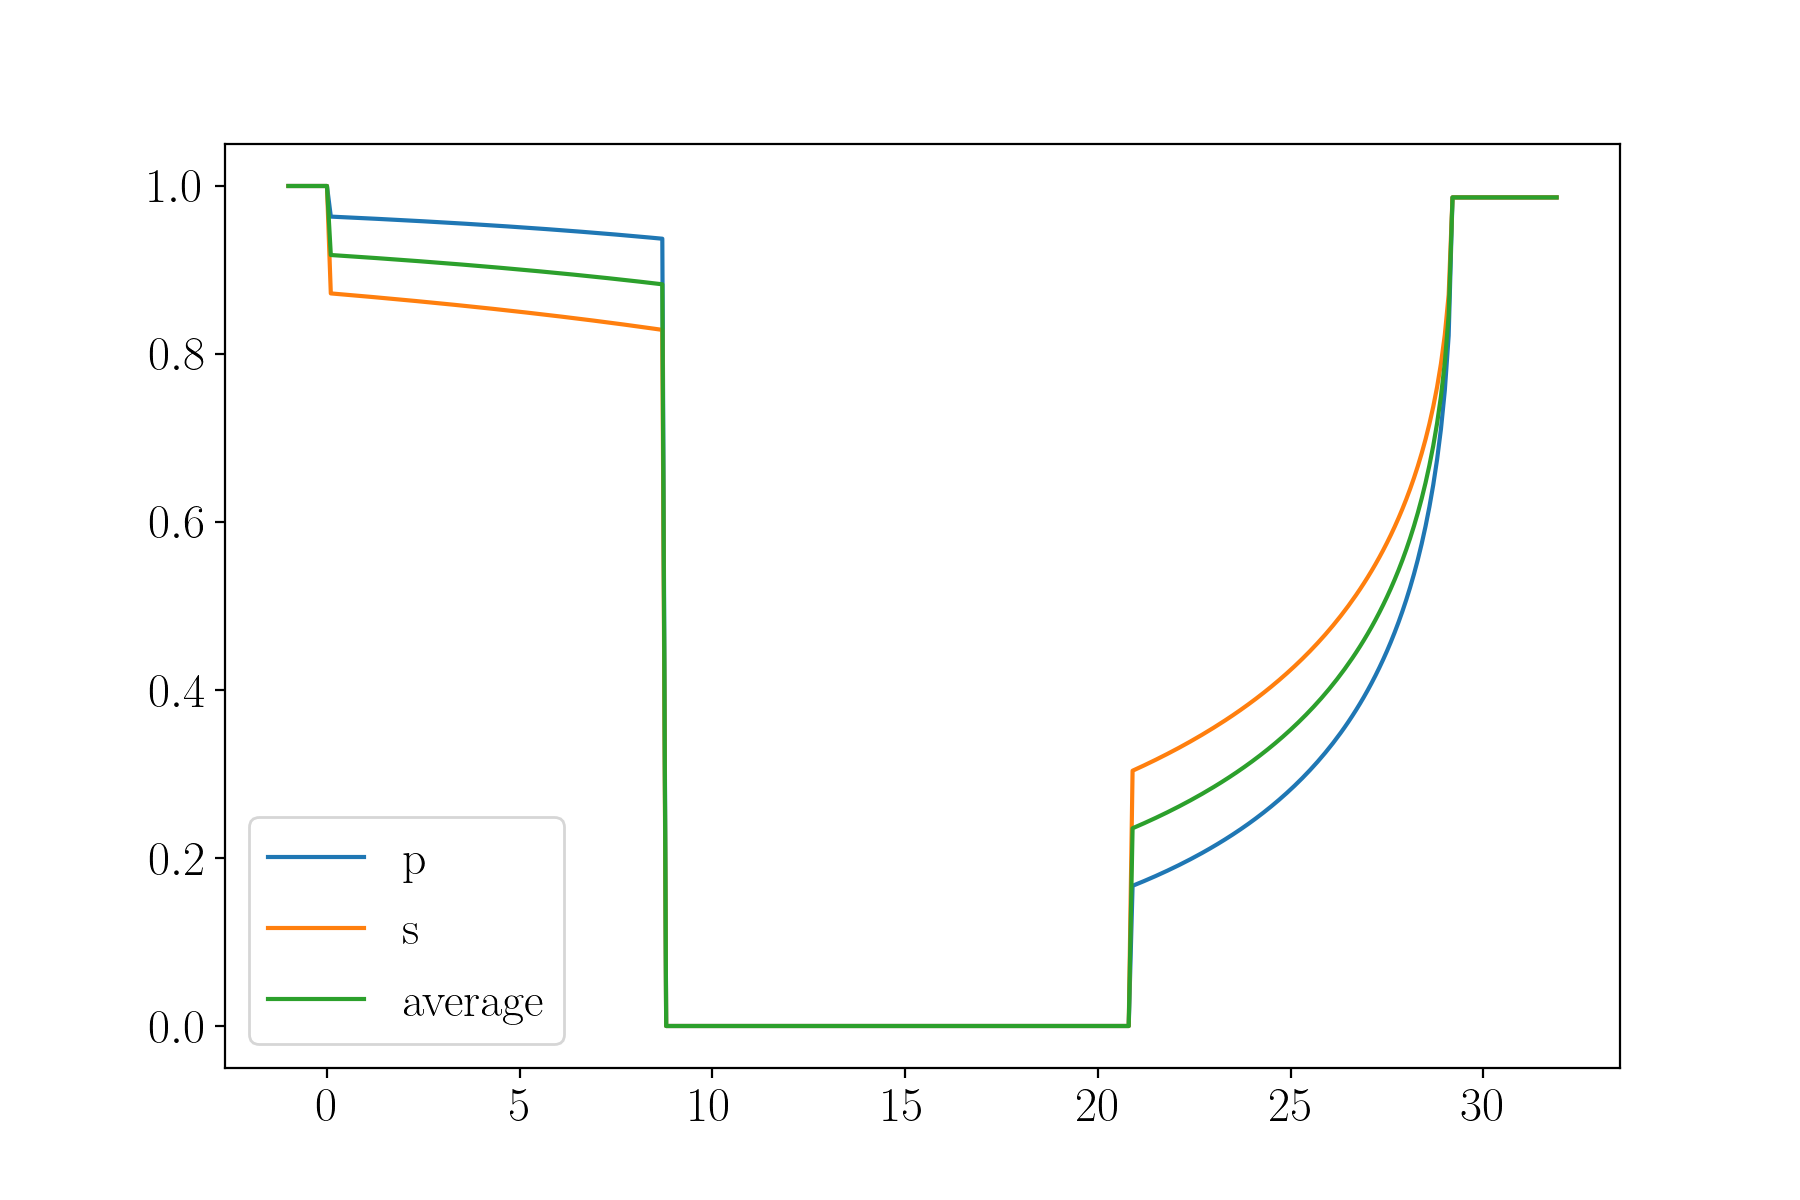

In [141]:
plt.figure(figsize=(9,6))
plt.plot(y0s, I_p_constrained, label='p')
plt.plot(y0s, I_s_constrained, label='s')
plt.plot(y0s, 0.5*(I_p_constrained + I_s_constrained), label='average')
plt.legend()

## Circularity of the capillary

In [141]:
R1 = 300
R2 = 150

def trace(b, extension=20, n0=1., n1=1.36, n2=1., allow_capillary_avoidance=True, verbose=False):
    
    if b < 0:
        points, thetaf = trace(-b, extension=extension, n0=n0, n1=n1, n2=n2,
                               allow_capillary_avoidance=allow_capillary_avoidance, verbose=verbose)
        points[:,1] *= -1
        thetaf *= -1
        return points, thetaf
    
    points = []
    points.append([-R1 - extension, b])
    if np.abs(b) > R1:
        if allow_capillary_avoidance:
            points.append([R1 + extension, b])
            if verbose:
                print('No interaction')
            return np.array(points), 0
        else:
            if verbose:
                print('No interaction')
            return np.array(points), np.nan
    
    
    theta0 = np.arcsin(b/R1)
    x1 = -R1*np.cos(theta0)
    y1 = b
    
    points.append([x1, y1])
    
    q = n0/n1*np.sin(theta0)
    if q > 1:
        if verbose:
            print('Total reflection')
        return np.array(points), np.nan
    theta1 = np.arcsin(q)
    m = np.tan(theta1 - theta0)
    
    x = sympy.Symbol('x')
    
    sol = solve((y1 + m*(x - x1))**2 - (R2**2 - x**2), x)
    x2 = complex(sol[0])
    if np.imag(x2) != 0:
        # no interaction with the inner circle
        alpha2 = theta0 + np.pi - 2*theta1
        x2 = -R1*np.cos(alpha2)
        y2 = R1*np.sin(alpha2)
        
        points.append([x2,y2])
        
        thetaf_rel = theta0
        thetaf = np.pi - alpha2 - thetaf_rel
        
        yf = y2 + np.tan(thetaf)*(R1 + extension - x2)
        points.append([R1 + extension, yf])
        return np.array(points), thetaf
    
    
    x2 = np.real(x2)
    y2 = y1 + m*(x2 - x1)
    points.append([x2, y2])
    alpha2 = np.arccos(-x2/R2)
    
#     print(f'{alpha2 = }')
    
    theta2 = theta1 + alpha2 - theta0
    
    q = n1/n2*np.sin(theta2)
    if q > 1:
        if verbose:
            print('Total reflection')
        return np.array(points), np.nan
    theta3 = np.arcsin(q)
    
    alpha3 = alpha2 + np.pi - 2*theta3
#     print(f'{alpha3 = }')
    
    x3 = -R2*np.cos(alpha3)
    y3 = R2*np.sin(alpha3)
    points.append([x3,y3])
    
    alpha4 = alpha3 + alpha2 - theta0
    x4 = -R1*np.cos(alpha4)
    y4 = R1*np.sin(alpha4)
    points.append([x4,y4])
    
    thetaf_rel = theta0
    thetaf = np.pi - alpha4 - thetaf_rel
    
    yf = y4 + np.tan(thetaf)*(R1 + extension - x4)
    points.append([R1 + extension, yf])
    return np.array(points), thetaf
    

<IPython.core.display.Javascript object>


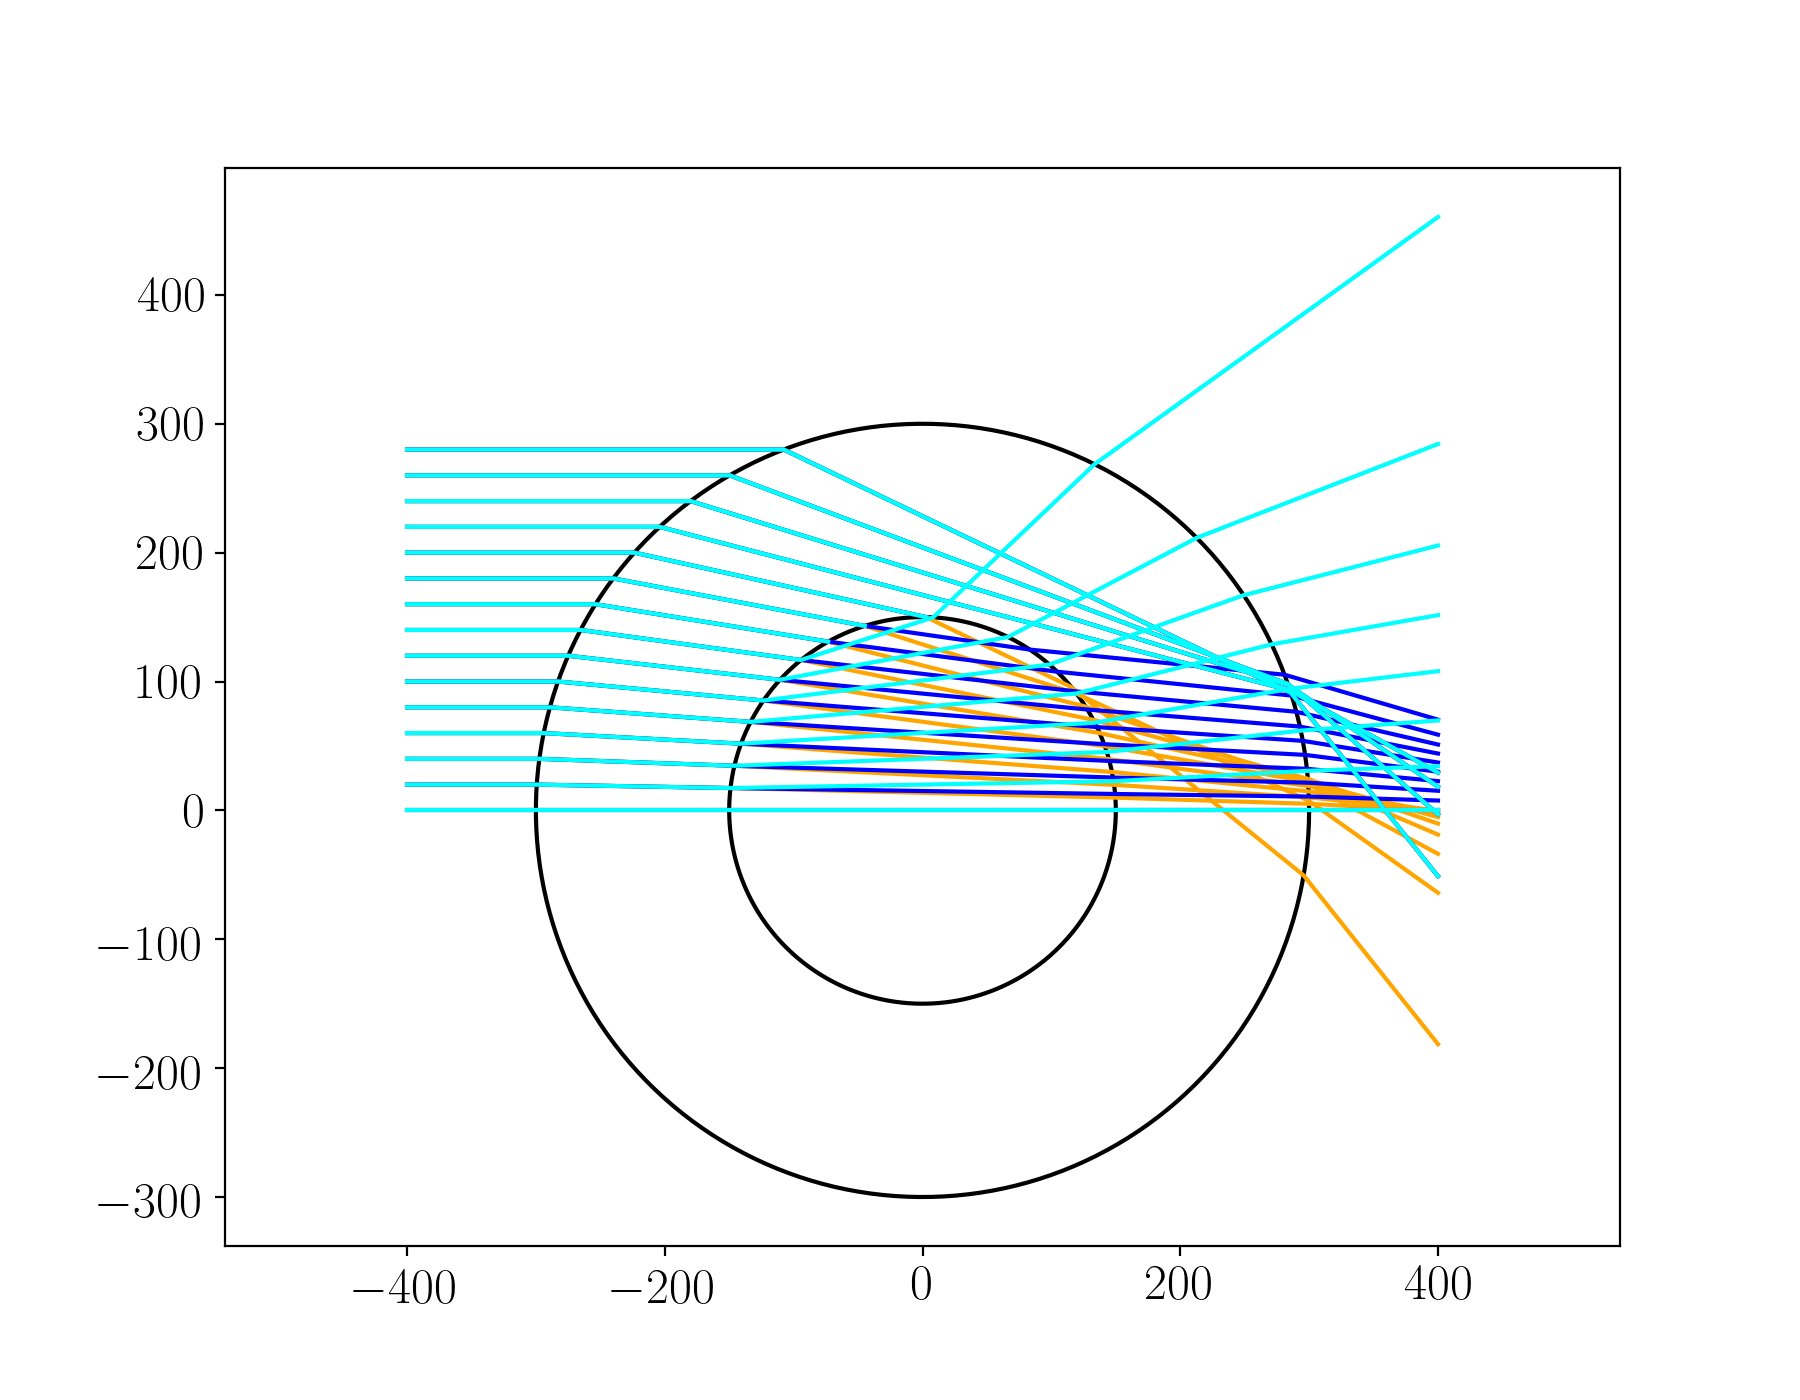

In [90]:
%matplotlib notebook
fig,ax = plt.subplots(figsize=(9,7))
ax.axis('equal')

alphas = np.linspace(0,2*np.pi, 200)
plt.plot(R1*np.cos(alphas), R1*np.sin(alphas), color='black')
plt.plot(R2*np.cos(alphas), R2*np.sin(alphas), color='black')



In [93]:
for b in np.arange(0, 300, 20):
    points, thetaf = trace(b,n2=1., extension=100)
    plt.plot(points[:,0], points[:,1], color='cyan')

### Collected intensity

In [149]:
R_f = 500 # radius of the optical fiber

n1 = 1.36 # capillary
n2 = 1.33 # liquid
extension = 400

v_offset = 250

v_step = 5 # for simulating rays

theta_max = np.pi/2

v_misalignment = 0
h_misalignment = 0

v_misalignment += v_offset


ys = np.arange(-R_f, R_f + v_step, v_step)
intensities = 2*np.sqrt(R_f**2 - ys**2)
bs = ys + v_offset

I_in = np.sum(intensities)

end_points = []
end_thetas = []
valid_indices = []

for i,b in enumerate(bs):
    points, thetaf = trace(b, n1=n1, n2=n2, extension=extension, allow_capillary_avoidance=False)
    if np.isfinite(thetaf):
        end_points.append(points[-1][1])
        end_thetas.append(thetaf)
        valid_indices.append(i)
    else:
        end_points.append(np.nan)
        end_thetas.append(np.nan)

valid_indices = np.array(valid_indices)
end_points = np.array(end_points)[valid_indices]
end_thetas = np.array(end_thetas)[valid_indices]
end_intensities = intensities[valid_indices]


I_out = 0
v_indices = []

for i,b in enumerate(end_points):
    if np.abs(b - v_misalignment) > R_f:
        continue
    if np.abs(end_thetas[i]) > theta_max:
        continue
    v_indices.append(i)
    I1 = end_intensities[i]
    I2 = 2*np.sqrt(R_f**2 - (b - v_misalignment)**2)
    
    I = np.min([I1, I2 - h_misalignment])
    I_out += np.max([I, 0])
    
print(f'Collected {I_out/I_in*100}% of the incoming light')

Collected 44.47890486123062% of the incoming light


In [159]:
R_f = 500 # radius of the optical fiber

n1 = 1.36 # capillary
extension = 400

v_offsets = np.linspace(0,250,11)

v_step = 5 # for simulating rays

theta_max = np.pi/8

v_misalignment0 = 0
h_misalignment = 0

Is = []
for v in tqdm(v_offsets):
    for n2 in [1., 1.467, 1.33]:

        v_offset = v

        v_misalignment = v_misalignment0 +  v_offset


        ys = np.arange(-R_f, R_f + v_step, v_step)
        intensities = 2*np.sqrt(R_f**2 - ys**2)
        bs = ys + v_offset

        I_in = np.sum(intensities)

        end_points = []
        end_thetas = []
        valid_indices = []

        for i,b in enumerate(bs):
            points, thetaf = trace(b, n1=n1, n2=n2, extension=extension, allow_capillary_avoidance=False)
            if np.isfinite(thetaf):
                end_points.append(points[-1][1])
                end_thetas.append(thetaf)
                valid_indices.append(i)
            else:
                end_points.append(np.nan)
                end_thetas.append(np.nan)

        valid_indices = np.array(valid_indices)
        end_points = np.array(end_points)[valid_indices]
        end_thetas = np.array(end_thetas)[valid_indices]
        end_intensities = intensities[valid_indices]


        I_out = 0
        v_indices = []

        for i,b in enumerate(end_points):
            if np.abs(b - v_misalignment) > R_f:
                continue
            if np.abs(end_thetas[i]) > theta_max:
                continue
            v_indices.append(i)
            I1 = end_intensities[i]
            I2 = 2*np.sqrt(R_f**2 - (b - v_misalignment)**2)

            I = np.min([I1, I2 - h_misalignment])
            I_out += np.max([I, 0])
            
        Is.append(I_out/I_in*100)

#         print(f'Collected {I_out/I_in*100}% of the incoming light')

df = pd.DataFrame(data=[], columns=['v offset','I_a', 'I ol', 'I w'])
for i, v in enumerate(v_offsets):
    df.loc[len(df)] = [v, Is[3*i], Is[3*i + 1], Is[3*i + 2]]
    
df

100%|██████████| 11/11 [03:58<00:00, 21.67s/it]


,v offset,I_a,I ol,I w
0,0.0,28.424147,34.578860,48.971233
1,25.0,28.365127,34.348512,48.895887
2,50.0,28.181958,33.980711,48.638725
3,75.0,27.856638,33.516673,48.143196
4,100.0,27.280260,32.952194,47.406349
5,125.0,26.725597,32.281805,46.489472
6,150.0,25.983913,31.498456,45.404410
7,175.0,25.134875,30.593048,44.141201
8,200.0,24.190526,29.553713,42.680666
9,225.0,23.155709,28.364697,40.995837


In [160]:
# df.to_csv('I_v_offset_theta_max22.5.csv', index=False)

<IPython.core.display.Javascript object>


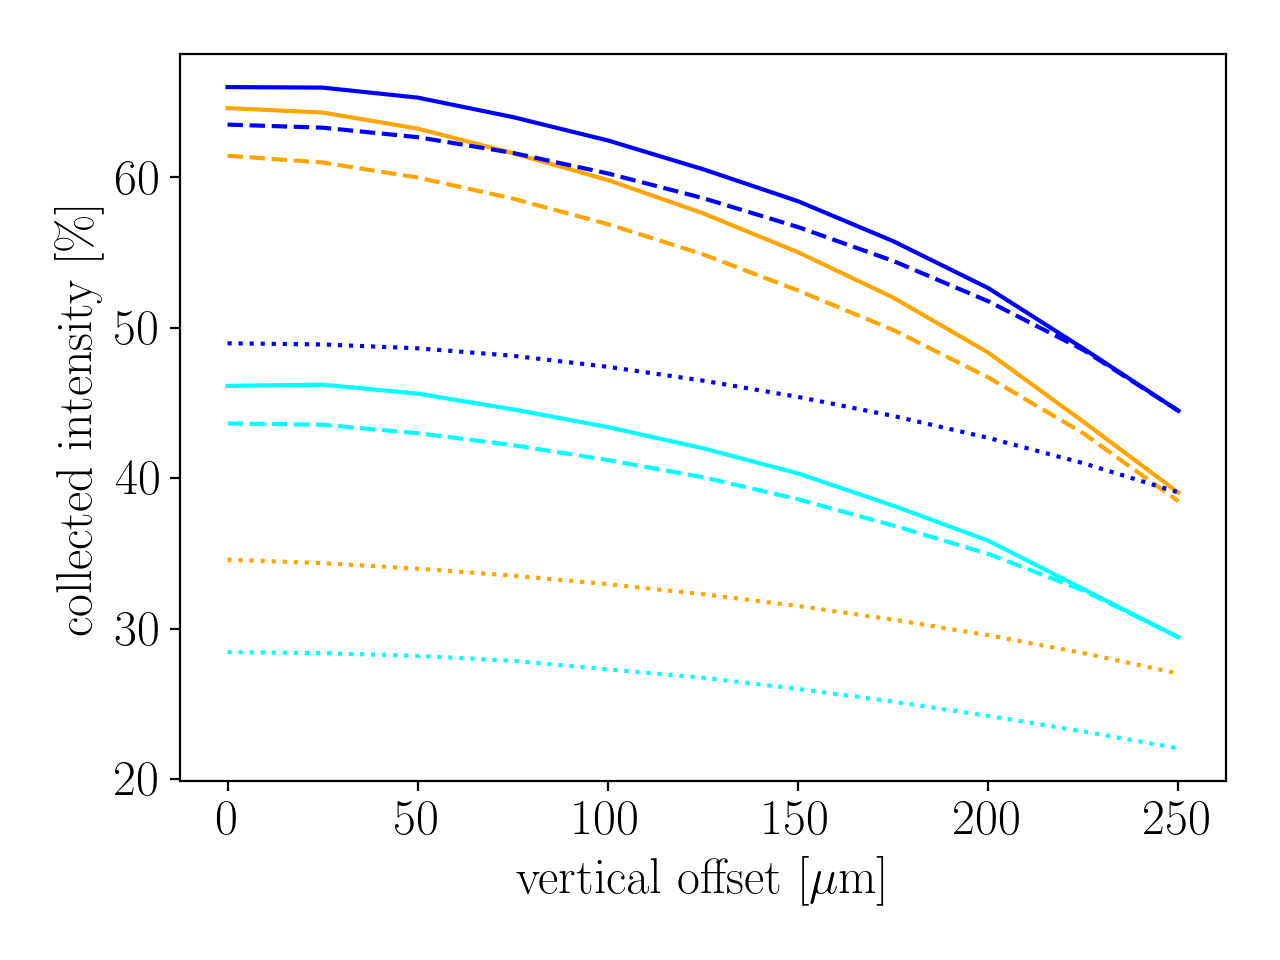

In [165]:
df22 = pd.read_csv('I_v_offset_theta_max22.5.csv')
df45 = pd.read_csv('I_v_offset_theta_max45.csv')
df90 = pd.read_csv('I_v_offset_theta_max90.csv')

dfs = [df90, df45, df22]
linestyles = [None, 'dashed', 'dotted']

fig,ax = plt.subplots()

for i,df in enumerate(dfs):
    plt.plot(df['v offset'], df['I_a'], color='cyan', linestyle=linestyles[i])
    plt.plot(df['v offset'], df['I ol'], color='orange', linestyle=linestyles[i])
    plt.plot(df['v offset'], df['I w'], color='blue', linestyle=linestyles[i])
    
plt.xlabel('vertical offset [$\mu$m]')
plt.ylabel('collected intensity [\%]')

fig.tight_layout()

<IPython.core.display.Javascript object>


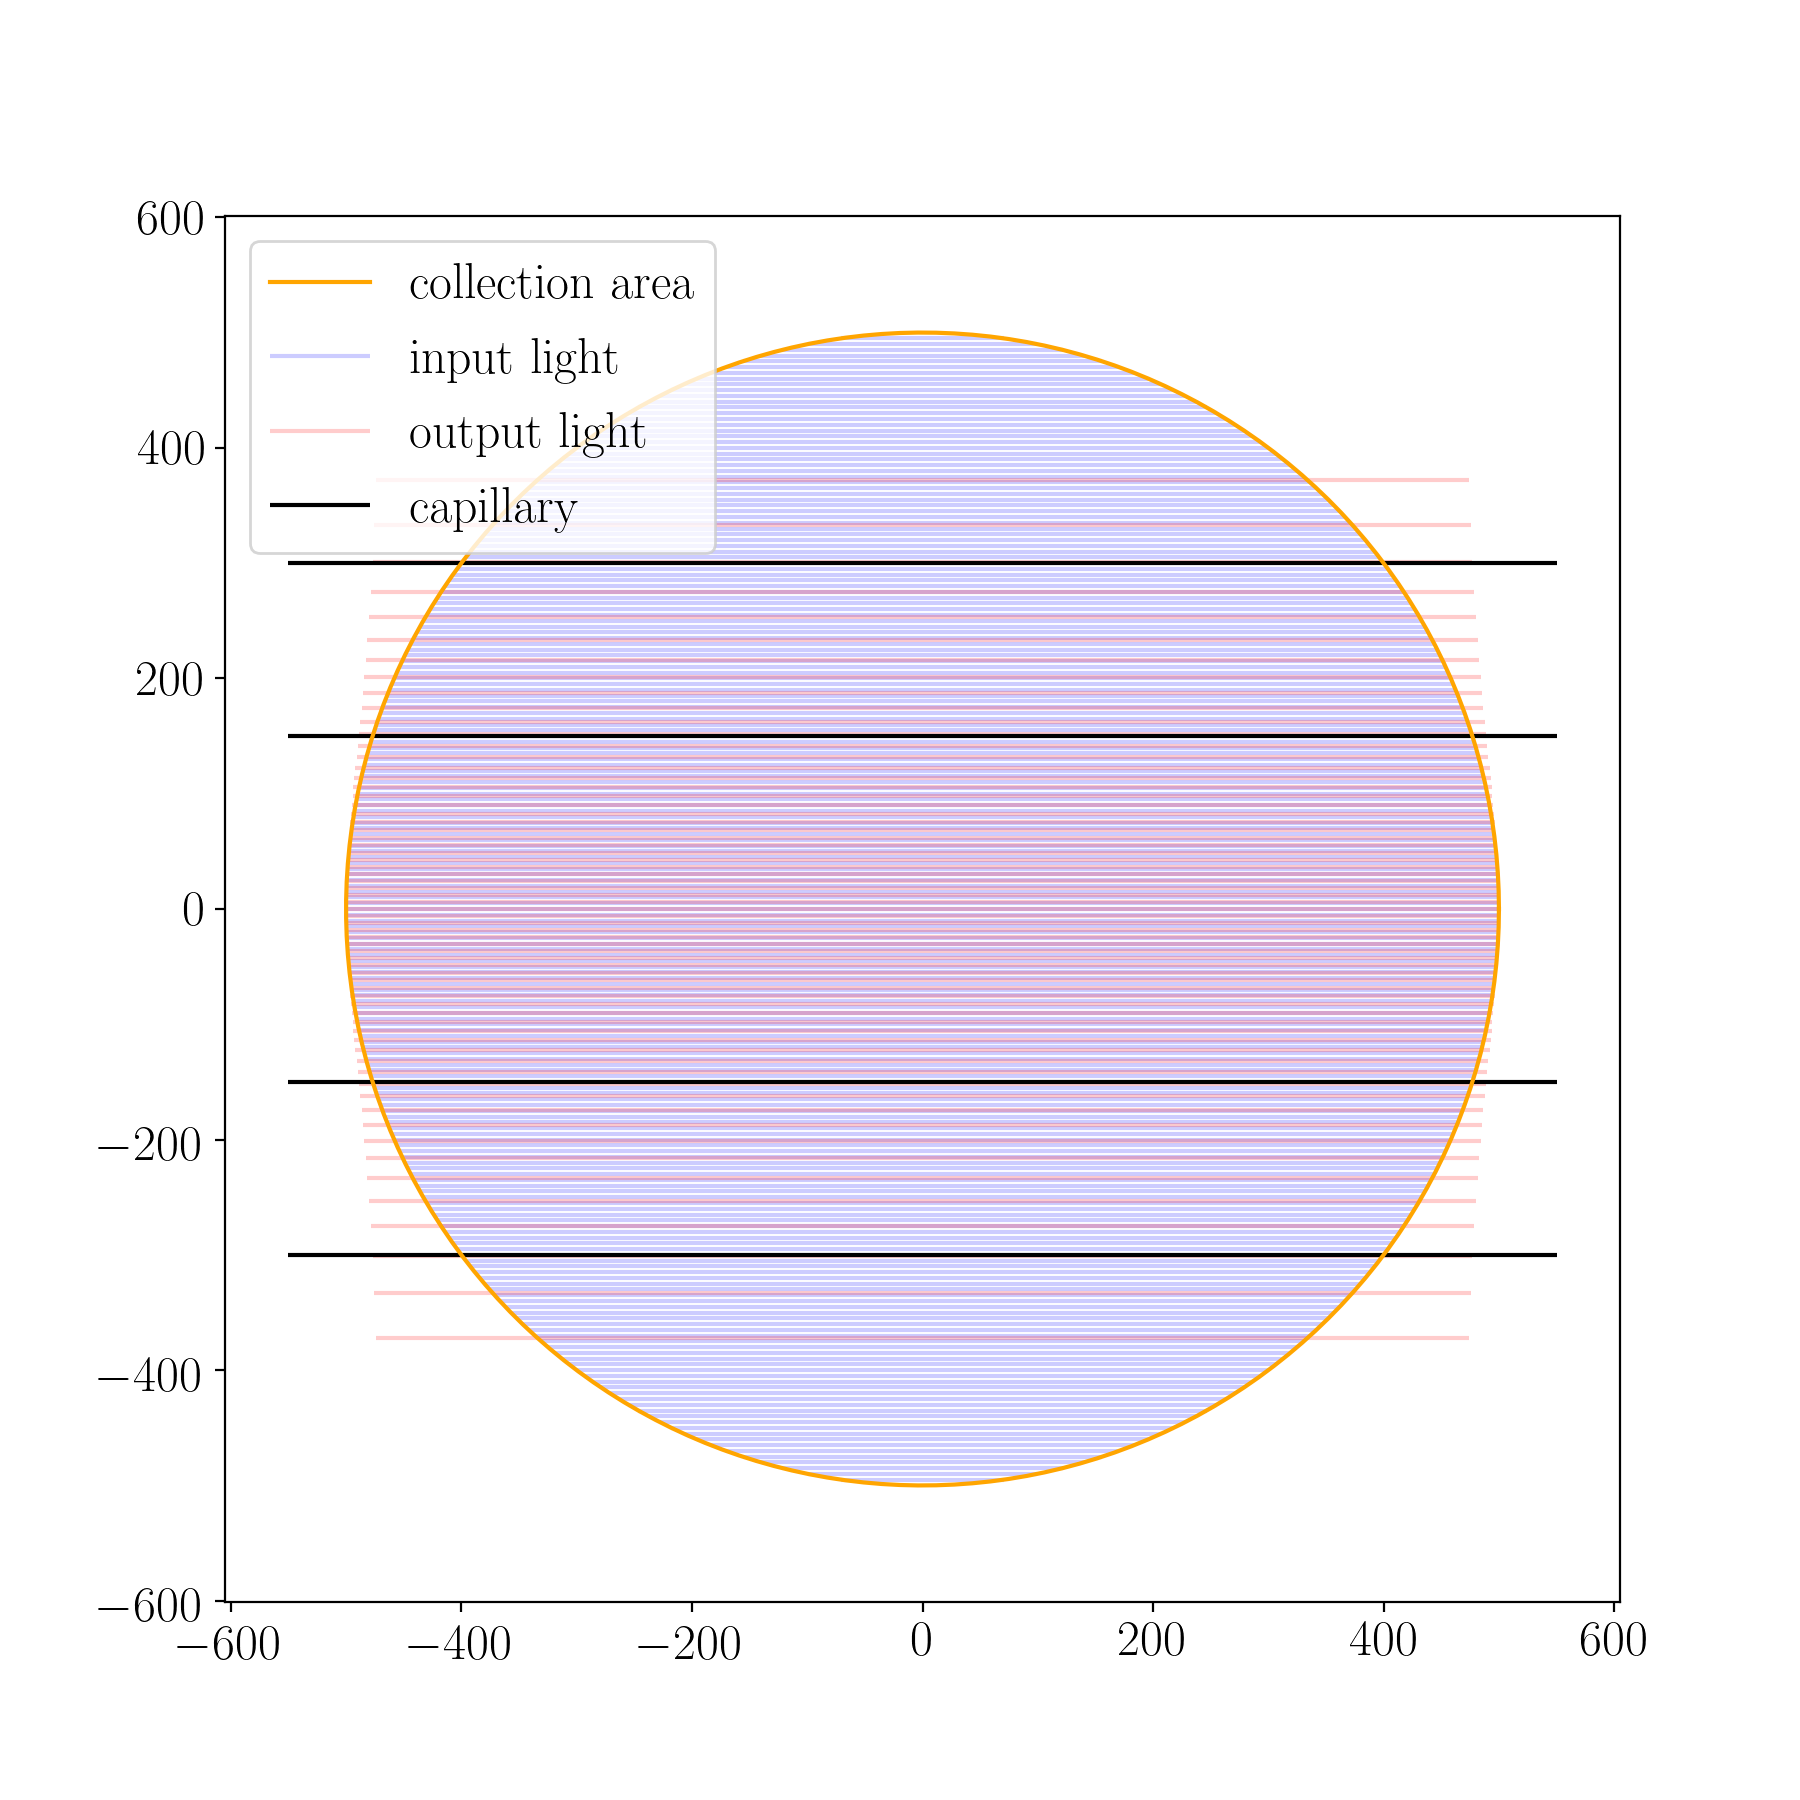

In [139]:
fig, ax = plt.subplots(figsize = (9,9))
ax.axis('equal')

label = 'input light'
for i,b in enumerate(bs):
    plt.hlines([b], *(np.array([-0.5,0.5])*intensities[i]), color='blue', alpha = 0.2, label=label)
    label = None

label = 'output light'
for i,b in enumerate(end_points[v_indices]):
    plt.hlines([b], *(np.array([-0.5,0.5])*end_intensities[v_indices][i]),
               color='red', alpha=0.2, label=label)
    label = None

plt.hlines([-R1, -R2, R2, R1], *ax.get_xlim(), color='black', alpha=1, label='capillary')

plt.plot(h_misalignment + R_f*np.cos(alphas), v_misalignment + R_f*np.sin(alphas),
         color='orange', label='collection area')

plt.legend(loc='upper left')

## Propagation of light in optical fiber

In [132]:
n_core = 1.4905
n_cladding = 1.3
L = 660*10**3 # lenght of the fiber [um]
core_radius = 500

theta_c = np.arcsin(n_cladding/n_core)
q = n_core*np.sin(np.pi/2 - theta_c)
theta_max = np.pi/2
if q < 1:
    theta_max = np.arcsin(q)
    
print(f'{theta_max*180/np.pi = }')

def intensity_drop(theta, x=0):
    if np.abs(x) >= core_radius:
        return 0
    thickness = 2*np.sqrt(core_radius**2 - x**2)
    
    theta_in_core = np.abs(np.arcsin(np.sin(theta)/n_core))
    print(theta_in_core)
    
    refl = 0.5*(reflectance(np.pi/2 - theta_in_core, n_cladding/n_core, polarization='p') +
                reflectance(np.pi/2 - theta_in_core, n_cladding/n_core, polarization='s'))
    print(refl)
    n_reflections = int(L*np.tan(theta_in_core)/thickness)
    
    return refl**n_reflections

theta_max*180/np.pi = 46.81119434462881


In [126]:
intensity_drop(np.pi/2)

0.7354431068288888
0.011858091386488774


0.0